#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input,concatenate
from keras.backend import clear_session
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
data = pd.read_csv(path+ 'data01_train.csv')
test = pd.read_csv(path+'data01_test.csv')

data.drop(columns='subject' , inplace = True)
test.drop(columns='subject' , inplace = True)

#### 2) 기본 정보 조회

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
target = 'Activity'

x = data.drop(columns=target)
y = data[target]

x.shape, y.shape

((5881, 561), (5881,))

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x = scaler.fit_transform(x)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()

y = le.fit_transform(y)

print(y)
print('*'*50)
print(le.classes_)

# 0	LAYING
# 1	SITTING
# 2	STANDING
# 3	WALKING
# 4	WALKING_DOWNSTAIRS
# 5	WALKING_UPSTAIRS

[2 0 2 ... 0 5 1]
**************************************************
['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size= .3)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1

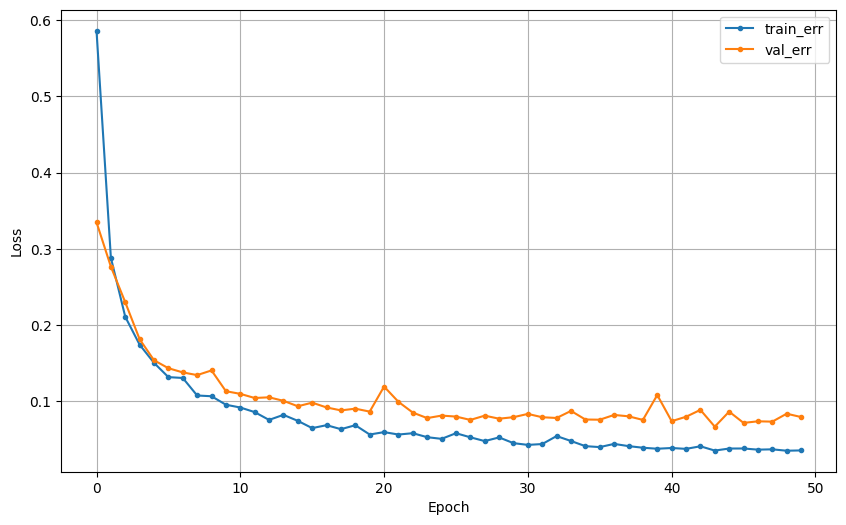

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.969971671388102
[[334   0   0   0   0   0]
 [  3 305   2   0   0   0]
 [  0  35 278   0   0   0]
 [  0   0   0 291   0   1]
 [  0   0   0   0 237   2]
 [  0   0   0   7   3 267]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       334
           1       0.90      0.98      0.94       310
           2       0.99      0.89      0.94       313
           3       0.98      1.00      0.99       292
           4       0.99      0.99      0.99       239
           5       0.99      0.96      0.98       277

    accuracy                           0.97      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.97      0.97      0.97      1765



In [ ]:
# input 설정

nfeatures = x_train.shape[1]
nfeatures

# 모델 구조선언

model = Sequential([Input(shape = (nfeatures,)),
                  Dense(6, activation='softmax')
                   ])

# model 컴파일
model.compile(optimizer = Adam(learning_rate=0.01),  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 학습
result = model.fit(x_train, y_train, epochs = 50, validation_split = .2 ,verbose = 0).history
dl_history_plot(result)

pred = model.predict(x_val)
pred_1 = pred.argmax(axis = 1)

print(accuracy_score(y_val, pred_1))
print(confusion_matrix(y_val, pred_1))
print(classification_report(y_val, pred_1))

### (2) 모델2

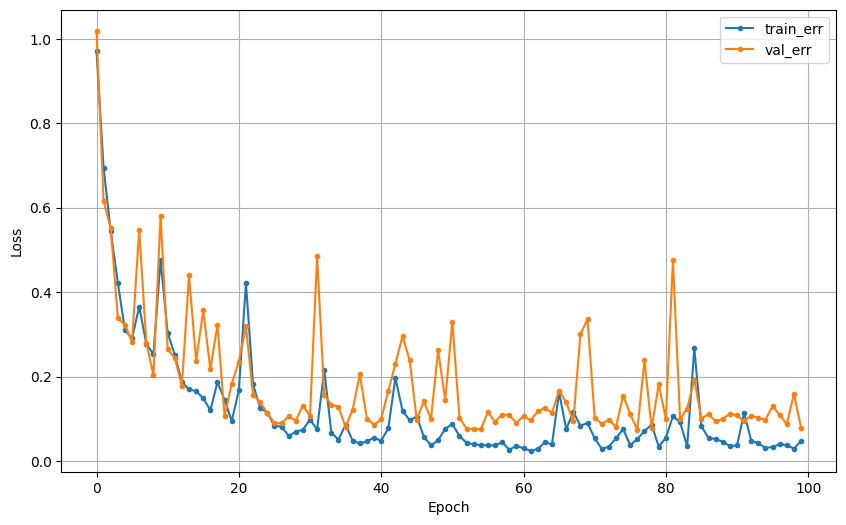

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
0.9813031161473088
[[334   0   0   0   0   0]
 [  2 297  11   0   0   0]
 [  0  10 303   0   0   0]
 [  0   0   0 287   0   5]
 [  0   0   0   0 236   3]
 [  0   0   0   2   0 275]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       334
           1       0.97      0.96      0.96       310
           2       0.96      0.97      0.97       313
           3       0.99      0.98      0.99       292
           4       1.00      0.99      0.99       239
           5       0.97      0.99      0.98       277

    accuracy                           0.98      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.98      0.98      0.98      1765



In [ ]:
# input 설정

nfeatures = x_train.shape[1]
nfeatures

# 모델 구조
model = Sequential([Input(shape =(nfeatures,)),
                   Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(6, activation='softmax')
                   ])
# 컴파일
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# 학습
result = model.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
dl_history_plot(result)
# 평가
pred = model.predict(x_val)
pred_1 = pred.argmax(axis = 1)

print(accuracy_score(y_val, pred_1))
print(confusion_matrix(y_val, pred_1))
print(classification_report(y_val, pred_1))

### (3) 모델3

Run 1/3


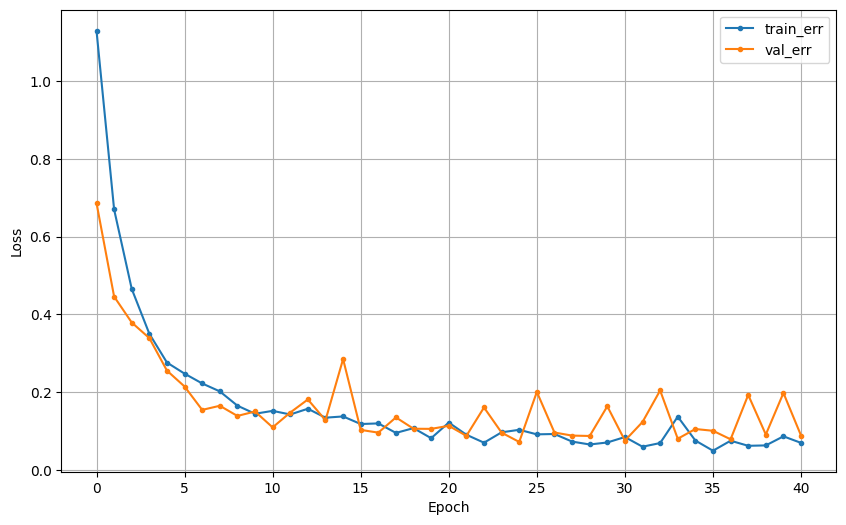

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 run 1:  0.97507
[[334   0   0   0   0   0]
 [  4 299   7   0   0   0]
 [  0  23 288   1   0   1]
 [  0   0   0 287   2   3]
 [  0   0   0   0 237   2]
 [  0   0   0   1   0 276]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       334
           1       0.93      0.96      0.95       310
           2       0.98      0.92      0.95       313
           3       0.99      0.98      0.99       292
           4       0.99      0.99      0.99       239
           5       0.98      1.00      0.99       277

    accuracy                           0.98      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.98      0.98      0.97      1765

Run 2/3


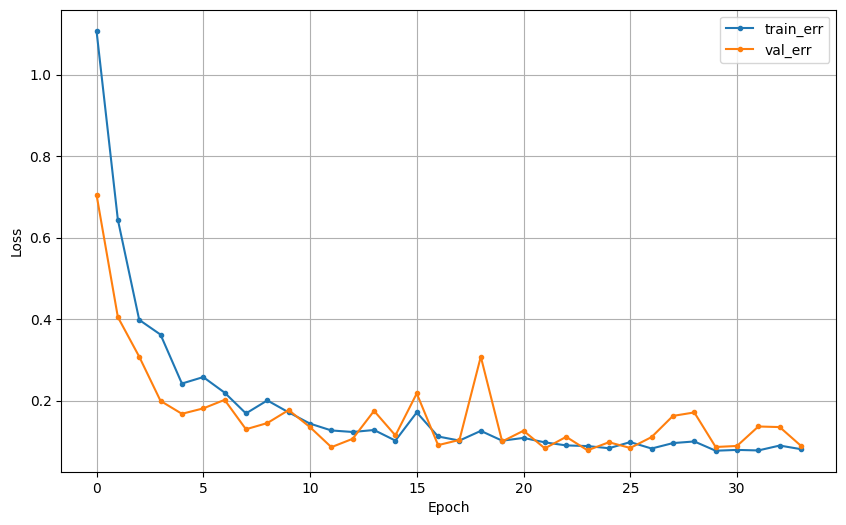

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 run 2:  0.97224
[[334   0   0   0   0   0]
 [  3 293  14   0   0   0]
 [  0   8 305   0   0   0]
 [  0   0   0 287   0   5]
 [  0   0   0   0 222  17]
 [  0   0   0   2   0 275]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       334
           1       0.97      0.95      0.96       310
           2       0.96      0.97      0.97       313
           3       0.99      0.98      0.99       292
           4       1.00      0.93      0.96       239
           5       0.93      0.99      0.96       277

    accuracy                           0.97      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.97      0.97      0.97      1765

Run 3/3


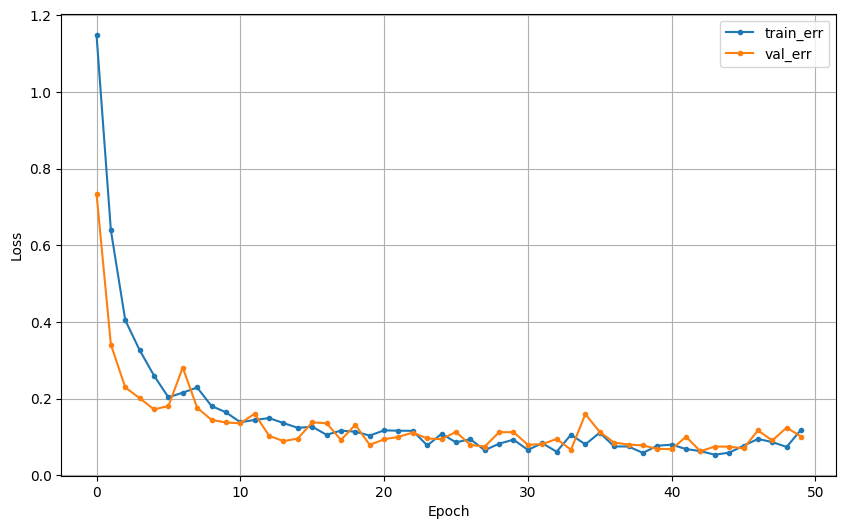

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 run 3:  0.98074
[[334   0   0   0   0   0]
 [  6 292  12   0   0   0]
 [  0   8 305   0   0   0]
 [  0   0   0 291   0   1]
 [  0   0   0   0 234   5]
 [  0   0   0   2   0 275]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       334
           1       0.97      0.94      0.96       310
           2       0.96      0.97      0.97       313
           3       0.99      1.00      0.99       292
           4       1.00      0.98      0.99       239
           5       0.98      0.99      0.99       277

    accuracy                           0.98      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.98      0.98      0.98      1765

[0.975070821529745, 0.9722379603399434, 0.9807365439093484]
0.9760151085930122
0.003533198665508889


In [ ]:
# 함수 정의
def train_and_evaluate(x_train, y_train, x_val, y_val, nfeatures, runs=3):
    accuracy_list = []
    best_model_path = "best_model.keras"
    for run in range(runs):
        print(f"Run {run + 1}/{runs}")

        mc = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max')
        er = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

        # 모델 구조 선언 (dropout 도 사용)
        model = Sequential([
            Input(shape=(nfeatures,)),
            Dense(512, activation='relu'),
            Dropout(0.2),
            Dense(256, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(6, activation='softmax')
        ])

        # # 모델 구조 선언 (er만 사용)
        # model = Sequential([
        #     Input(shape=(nfeatures,)),
        #     Dense(512, activation='relu'),
        #     Dense(256, activation='relu'),
        #     Dense(128, activation='relu'),
        #     Dense(64, activation='relu'),
        #     Dense(32, activation='relu'),
        #     Dense(6, activation='softmax')
        # ])

        # # 모델 구조 선언 (er, L2)
        # model = Sequential([
        #     Input(shape=(nfeatures,)),
        #     Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(6, activation='softmax')
        # ])

        # 모델 컴파일
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # 학습
        result = model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[er,mc], verbose=0).history
        dl_history_plot(result)

        # 평가
        pred = model.predict(x_val)
        pred_1 = pred.argmax(axis=1)
        accuracy = accuracy_score(y_val, pred_1)
        accuracy_list.append(accuracy)

        print(f" run {run + 1}: {accuracy: .5f}")
        print(confusion_matrix(y_val, pred_1))
        print(classification_report(y_val, pred_1))

    return accuracy_list

# 호출 예시
accuracy_results = train_and_evaluate(x_train, y_train, x_val, y_val, nfeatures)

print(accuracy_results)


print(np.mean(accuracy_results))
print(np.std(accuracy_results))

### (4) 모델4

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2613 - loss: 1.7239 - val_accuracy: 0.4782 - val_loss: 1.4640
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4179 - loss: 1.4705 - val_accuracy: 0.5515 - val_loss: 1.2260
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5038 - loss: 1.2203 - val_accuracy: 0.7981 - val_loss: 0.6208
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6488 - loss: 0.8338 - val_accuracy: 0.7938 - val_loss: 0.5609
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7117 - loss: 0.7342 - val_accuracy: 0.8757 - val_loss: 0.3685
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7798 - loss: 0.5700 - val_accuracy: 0.9107 - val_loss: 0.3117
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7921 - loss: 0.5386 - val_accuracy: 0.9352 - val_loss: 0.2554
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8003 - loss: 0.4950 - val_accu

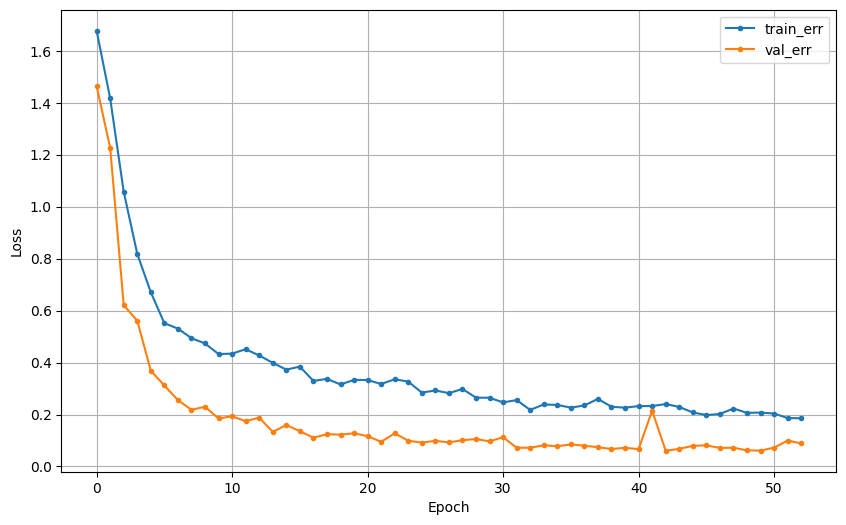

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[222   0   0   0   0   0]
 [  0 193  42   0   0   0]
 [  1   0 197   0   0   0]
 [  0   0   0 191   0   1]
 [  0   0   0   3 168   3]
 [  0   0   0   2   0 154]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      0.82      0.90       235
           2       0.82      0.99      0.90       198
           3       0.97      0.99      0.98       192
           4       1.00      0.97      0.98       174
           5       0.97      0.99      0.98       156

    accuracy                           0.96      1177
   macro avg       0.96      0.96      0.96      1177
weighted avg       0.96      0.96      0.96      1177

0.9558198810535259


In [ ]:
# 다중입력, early_stop, dropout

data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')

drop_col = ['subject']
data01_train.drop(columns = drop_col, axis=1, inplace=True)
data01_test.drop(columns = drop_col, axis=1, inplace=True)

data01_train['Activity'] = data01_train['Activity'].map({'LAYING' : 0, 'STANDING' : 1, 'SITTING' : 2, 'WALKING' : 3, 'WALKING_UPSTAIRS' : 4, 'WALKING_DOWNSTAIRS' : 5})
data01_train.head()

x = data01_train.drop(['Activity'], axis=1)
y = data01_train['Activity']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 1)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

n = x_train.shape[1]

x_train_features = list(x.columns)

acc_vars = [i for i, col in enumerate(x_train_features) if 'Acc' in col]
gyro_vars = [i for i, col in enumerate(x_train_features) if 'Gyro' in col]
other_vars = [i for i, col in enumerate(x_train_features) if col not in [x_train_features[i] for i in acc_vars + gyro_vars]]

nfeatures1 = len(acc_vars)
nfeatures2 = len(gyro_vars)
nfeatures3 = len(other_vars)

input_1 = Input(shape=(nfeatures1,), name='input_1')
input_2 = Input(shape=(nfeatures2,), name='input_2')
input_3 = Input(shape=(nfeatures3,), name='input_3')

hl1_1 = Dense(345, activation='relu')(input_1)
hl1_2 = Dense(213, activation='relu')(input_2)
hl1_3 = Dense(3, activation='relu')(input_3)

cbl = concatenate([hl1_1, hl1_2, hl1_3])

hl2 = Dense(8, activation='relu')(cbl)
hl2 = Dropout(0.2)(hl2)
output = Dense(6, activation='softmax')(hl2)

model4_1 = Model(inputs=[input_1, input_2, input_3], outputs=output)

model4_1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

min_de = 0.0001
pat = 10

es = EarlyStopping(monitor='val_loss', min_delta=min_de, patience=pat)

x_train_acc = np.array(x_train[:, acc_vars])
x_train_gyro = np.array(x_train[:, gyro_vars])
x_train_other = np.array(x_train[:, other_vars])

result4_1 = model4_1.fit([x_train_acc, x_train_gyro, x_train_other], y_train, epochs=100, validation_split=0.2, callbacks=[es]).history

dl_history_plot(result4_1)

x_val_acc = np.array(x_val[:, acc_vars])
x_val_gyro = np.array(x_val[:, gyro_vars])
x_val_other = np.array(x_val[:, other_vars])

pred4_1 = model4_1.predict([x_val_acc, x_val_gyro, x_val_other])
pred4_1 = np.argmax(pred4_1, axis=1)

print(confusion_matrix(y_val, pred4_1))
print(classification_report(y_val, pred4_1))
print(accuracy_score(y_val, pred4_1))

Run 1/3


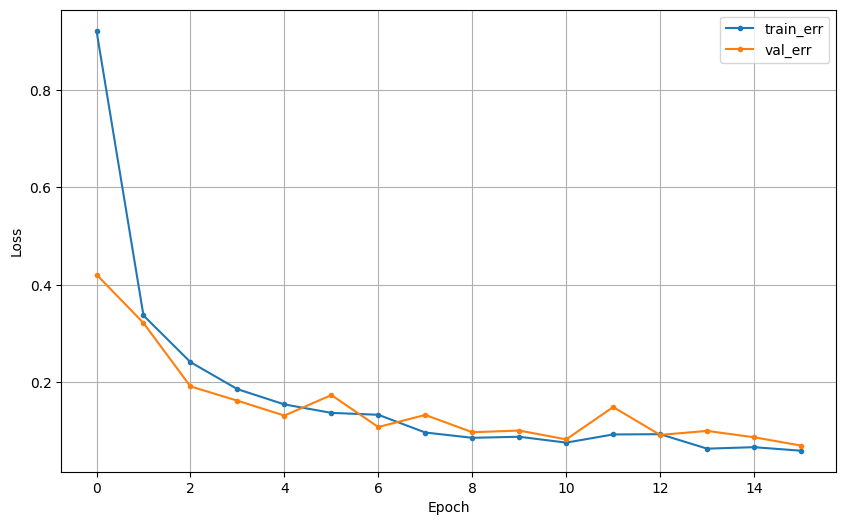

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 run 1:  0.97451
[[222   0   0   0   0   0]
 [  0 232   3   0   0   0]
 [  0  22 176   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   0 174   0]
 [  0   0   0   4   1 151]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.91      0.99      0.95       235
           2       0.98      0.89      0.93       198
           3       0.98      1.00      0.99       192
           4       0.99      1.00      1.00       174
           5       1.00      0.97      0.98       156

    accuracy                           0.97      1177
   macro avg       0.98      0.97      0.98      1177
weighted avg       0.98      0.97      0.97      1177

Run 2/3


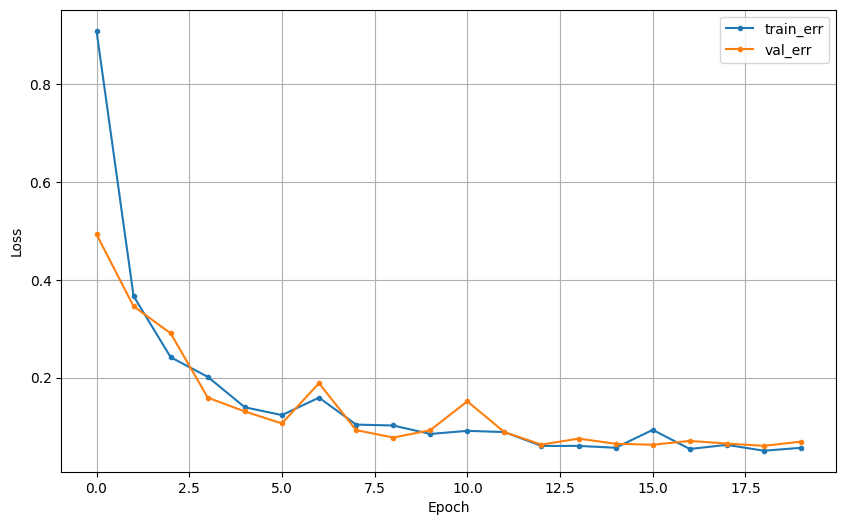

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 run 2:  0.97791
[[222   0   0   0   0   0]
 [  0 233   2   0   0   0]
 [  0  22 176   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   0 174   0]
 [  0   0   0   1   1 154]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.91      0.99      0.95       235
           2       0.99      0.89      0.94       198
           3       0.99      1.00      1.00       192
           4       0.99      1.00      1.00       174
           5       1.00      0.99      0.99       156

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

Run 3/3


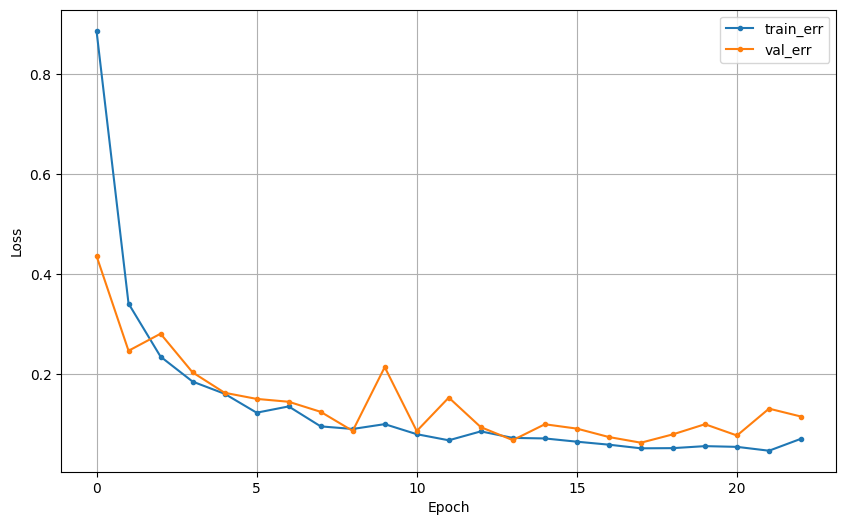

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 run 3:  0.96602
[[222   0   0   0   0   0]
 [  0 232   3   0   0   0]
 [  1  19 178   0   0   0]
 [  0   0   0 177   5  10]
 [  0   0   0   0 172   2]
 [  0   0   0   0   0 156]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.92      0.99      0.95       235
           2       0.98      0.90      0.94       198
           3       1.00      0.92      0.96       192
           4       0.97      0.99      0.98       174
           5       0.93      1.00      0.96       156

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177

[0.9745114698385726, 0.9779099405267629, 0.9660152931180969]
0.9728122344944775
0.005002413404886904


In [ ]:
# 함수 정의
def train_and_evaluate(x_train, y_train, x_val, y_val, nfeatures, runs=3):
    accuracy_list = []
    best_model_path = "best_model.keras"
    for run in range(runs):
        print(f"Run {run + 1}/{runs}")

        mc = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max')
        er = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=5)

        # 모델 구조 선언 (dropout 도 사용)
        model = Sequential([Input(shape=(nfeatures,)),
                     Dense(100, activation='relu'),
                     Dense(70, activation='relu'),
                     Dense(40, activation='relu'),
                     Dense(10, activation='relu'),
                     Dense(6, activation='softmax')
                    ])


        # # 모델 구조 선언 (er만 사용)
        # model = Sequential([
        #     Input(shape=(nfeatures,)),
        #     Dense(512, activation='relu'),
        #     Dense(256, activation='relu'),
        #     Dense(128, activation='relu'),
        #     Dense(64, activation='relu'),
        #     Dense(32, activation='relu'),
        #     Dense(6, activation='softmax')
        # ])

        # # 모델 구조 선언 (er, L2)
        # model = Sequential([
        #     Input(shape=(nfeatures,)),
        #     Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(6, activation='softmax')
        # ])

        # 모델 컴파일
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # 학습
        result = model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[er,mc], verbose=0).history
        dl_history_plot(result)

        # 평가
        pred = model.predict(x_val)
        pred_1 = pred.argmax(axis=1)
        accuracy = accuracy_score(y_val, pred_1)
        accuracy_list.append(accuracy)

        print(f" run {run + 1}: {accuracy: .5f}")
        print(confusion_matrix(y_val, pred_1))
        print(classification_report(y_val, pred_1))

    return accuracy_list

# 호출 예시
accuracy_results = train_and_evaluate(x_train, y_train, x_val, y_val, nfeatures)

print(accuracy_results)


print(np.mean(accuracy_results))
print(np.std(accuracy_results))

### 동적3개요인 모델링

In [ ]:
# 동적 모델 전처리(3개씩 끊은 데이터프레임)

temp = data.copy()

temp.drop(temp[temp['Activity'].isin(['STANDING', 'LAYING', 'SITTING'])].index, inplace=True)

temp = temp.dropna()

target = 'Activity'
x = temp.drop(target, axis = 1)
y = temp.loc[:, target]

scaler_d = MinMaxScaler()
x= scaler_d.fit_transform(x)

label_encoder_d = LabelEncoder()
y = label_encoder_d.fit_transform(y)

x_train_d, x_val_d, y_train_d, y_val_d = train_test_split(x,y,test_size=0.3, random_state=42)


nfeatures_d = x_train_d.shape[1]

In [ ]:
x_val_d.shape

(795, 561)

Run 1/3


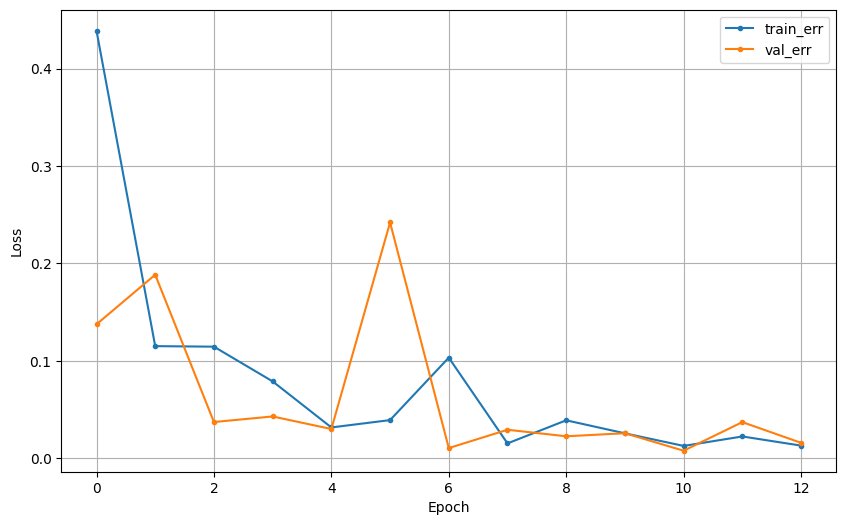

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 run 1:  0.98616
[[280   0   7]
 [  0 237   4]
 [  0   0 267]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       287
           1       1.00      0.98      0.99       241
           2       0.96      1.00      0.98       267

    accuracy                           0.99       795
   macro avg       0.99      0.99      0.99       795
weighted avg       0.99      0.99      0.99       795

Run 2/3


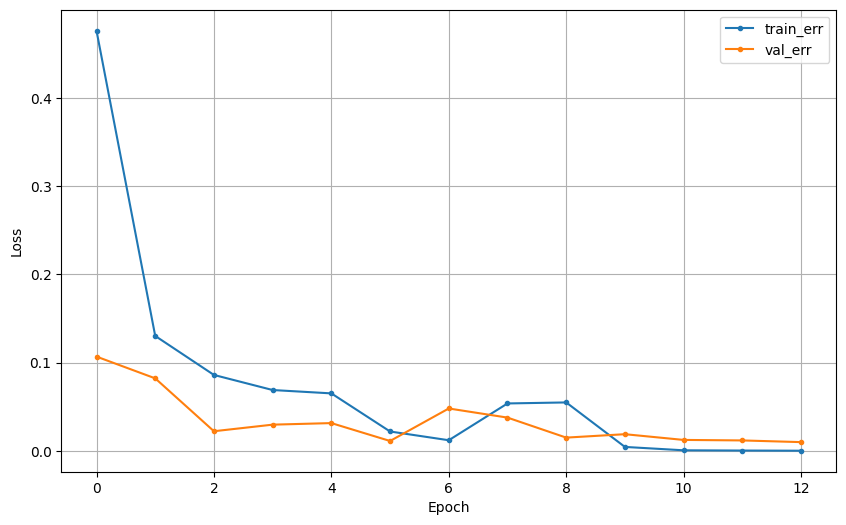

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 run 2:  0.99497
[[286   1   0]
 [  0 241   0]
 [  2   1 264]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       287
           1       0.99      1.00      1.00       241
           2       1.00      0.99      0.99       267

    accuracy                           0.99       795
   macro avg       0.99      1.00      1.00       795
weighted avg       0.99      0.99      0.99       795

Run 3/3


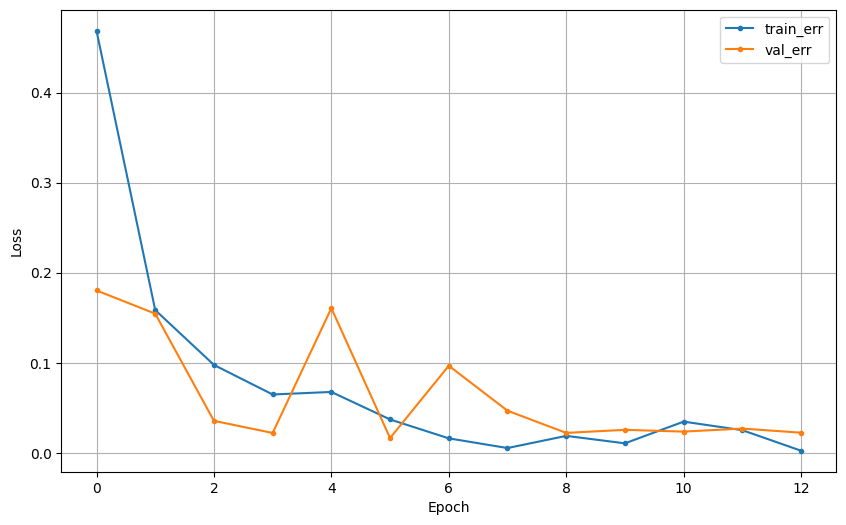

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 run 3:  0.99119
[[281   2   4]
 [  0 241   0]
 [  0   1 266]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       287
           1       0.99      1.00      0.99       241
           2       0.99      1.00      0.99       267

    accuracy                           0.99       795
   macro avg       0.99      0.99      0.99       795
weighted avg       0.99      0.99      0.99       795

[0.9861635220125786, 0.9949685534591195, 0.9911949685534591]
0.9907756813417191
0.003606844975699214


In [ ]:
# 함수 정의
def train_and_evaluate(x_train, y_train, x_val, y_val, nfeatures, runs=3):
    accuracy_list = []
    best_model_path = "best_model.keras"
    for run in range(runs):
        print(f"Run {run + 1}/{runs}")

        mc = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max')
        er = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=10)

        # 모델 구조 선언 (dropout 도 사용)
        model8 = Sequential([Input(shape=(nfeatures_d,)),
                     Dense(500, activation='relu'),
                     Dense(250, activation='relu'),
                     Dense(125, activation='relu'),
                     Dense(60, activation='relu'),
                     Dense(3, activation='softmax')
                    ])

        # 모델 컴파일
        model8.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # 학습
        result = model8.fit(x_train_d, y_train_d, epochs=100, validation_split=0.2, callbacks=[er,mc], verbose=0).history
        dl_history_plot(result)

        # 평가
        pred_d = model8.predict(x_val_d)
        pred_1_d = pred_d.argmax(axis=1)
        accuracy = accuracy_score(y_val_d, pred_1_d)
        accuracy_list.append(accuracy)

        print(f" run {run + 1}: {accuracy: .5f}")
        print(confusion_matrix(y_val_d, pred_1_d))
        print(classification_report(y_val_d, pred_1_d))

    return accuracy_list

# 호출 예시
accuracy_results = train_and_evaluate(x_train_d, y_train_d, x_val_d, y_val_d, nfeatures_d)

print(accuracy_results)


print(np.mean(accuracy_results))
print(np.std(accuracy_results))

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
from keras.models import load_model

best_model = load_model("best_model.keras")

In [ ]:
test = pd.read_csv('data01_test.csv')
test.drop(columns='subject', inplace = True) # 쓸모 없는 거 버리기

FileNotFoundError: [Errno 2] No such file or directory: 'data01_test.csv'

In [ ]:
# test : x,y 나누기

x = test.drop(columns=target)
y = test[target]

x = scaler.transform(x) # data와 동일
y = le.transform(y) # data와 동일, 라벨인코더

final_pred =  best_model.predict(x)
final_pred_1 = final_pred.argmax(axis = 1)
final_pred_1


print(accuracy_score(y, final_pred_1))
print(confusion_matrix(y, final_pred_1))
print(classification_report(y, final_pred_1))


# 미션 2-1
- 데이터 구성
- 동적, 정적 구분 모델 학습 및 성능 비교

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [ ]:
data = pd.read_csv('data01_train.csv')
test = pd.read_csv('data01_test.csv')

data.drop(columns='subject',inplace = True)
test.drop(columns='subject',inplace = True)

In [ ]:
test.columns

In [ ]:
# x,y 분리

target = 'Activity'

x = data.drop(columns=target, axis =1)
y = data[target]
y = y.map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                  'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
y.value_counts()

In [ ]:
x.columns

In [ ]:
# x,y 스케일링

scaler = MinMaxScaler()

x = scaler.fit_transform(x)
x

In [ ]:
# train, val  분리

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size= .3)

In [ ]:
# 입력정리

nfeatures = x_train.shape[1]
nfeatures

In [ ]:
# 모델 정의 functional

il = Input(shape = (nfeatures,))
hl1 = Dense(512, activation='relu')(il)
hl2 = Dense(256, activation='relu')(hl1)
hl3 = Dense(128, activation='relu')(hl2)
hl4 = Dense(64, activation='relu')(hl3)
hl5 = Dense(32, activation='relu')(hl4)
ol = Dense(1, activation='sigmoid')(hl5)

model = Model(inputs = il, outputs = ol)

model.summary()

In [ ]:
# 컴파일, 학습
er = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

best_model_path = "best_model_binary.keras"

mc = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max')

model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])



result = model.fit(x_train, y_train, epochs = 100, validation_split= 0.2, callbacks = [er,mc]).history

In [ ]:
dl_history_plot(result)

In [ ]:
pred = model.predict(x_val)

pred = np.where(pred >=0.5 , 1, 0)

print(classification_report(y_val, pred))

- 테스트 예측

In [ ]:
test.shape

In [ ]:
target = 'Activity'

x = test.drop(columns=target)
y = test[target]

x = scaler.transform(x)
y = y.map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                  'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})




In [ ]:
model = load_model('best_model_binary.keras')

In [ ]:
pred = model.predict(x)
pred_1 = np.where(pred >=0.5 , 1, 0)

pred_1

In [ ]:
y

In [ ]:
print(accuracy_score(y,pred_1))
print(confusion_matrix(y,pred_1))
print(classification_report(y, pred_1))